# Experiment Notebook

MATH 189 SP 2019 Final Project

Thitaree (Mint) Tanprasert & Julianne Lin

This project aims to recognize stock data patterns by encoding well-known patterns in the form of sequence of V-shaped vectors. Each V-shaped vector is encoded with 4 parameters: rotation angle, left attenna scaling, right atenna scaling, and shearing factor, with respect to a normalized V-shaped vector.

## Import necessary libraries

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import csv
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

## Helper functions

In [3]:
def read_data(file, att='open'):
    """ Read the specified attribute from data file.
        Default is 'open' attribute. 
    """
    
    df = pd.read_csv(file)
    return [float(x) for x in df[att]]

In [4]:
def get_Vectors(data):
    """ Extract V vectors from data (list). Each vector is represented
        as a sublist of coordinates [left_x, left_y, right_x, right_y],
        assuming that the dip of the V is at coordinate (0, 0). 
    """
    L = []
    
    # Get start index; ignore first increase
    st = 1
    while data[st] >= data[st-1]:
        st = st+1
    st -= 1
    
    Vs = [] # list of all V vectors
    Pts = [st+1]
    LPts = []
    i = st+1
    down = True
    while i < len(data):
        if down:
            if data[i] > data[i-1]:
                V = [st-(i-1), data[st]-data[i-1]] # left vector coordinates
                dip = i-1
                LPts.append(i)
                down = False
            i += 1
        else:
            if data[i] < data[i-1]:
                V = V + [(i-1)-dip, data[i-1]-data[dip]] # right vector coordinates
                Vs.append(V) # add vector to list
                Pts.append(i)
                if len(Pts) > 1:
                    L.append(Pts[-1]-Pts[-2])
                st = i-1
                down = True
            i += 1
            
    return Vs, Pts, LPts, np.round(np.median(L))

In [5]:
def dist(x, y):
    return np.sqrt(x**2 + y**2) # Euclidean distance

In [6]:
def getParams(v):
    """ Get rotation, scaling, and shearing parameters with formula according to the midterm paper. 
        The parameters are returned as a list.
    """
    
    A = 0.5*np.array([-v[0]+v[2], v[0]+v[2], -v[1]+v[3], v[1]+v[3]]) # A11, A12, A21, A22
    theta = np.arctan(A[2]/A[0])
    s_l = A[0]/np.cos(theta)
    s_r = A[3]-(A[1]*np.sin(theta))
    m = (A[1] + s_r*np.sin(theta))/(s_l*np.cos(theta))
    return [theta, s_l, s_r, m]

## Data Smoothing Experiment

Experiment with several level of smoothing with moving average. One round of convolution is one level of smoothing.

In [7]:
file_dir = 'individual_stocks_5yr'
files = [os.path.basename(elem) for elem in sorted(glob.glob(file_dir+'/*.csv'))]

In [8]:
file = file_dir + '/' + files[0]
data = read_data(file)[300:500] # Read a 200-day window of data
_, Pts, _, m = get_Vectors(data)
conv_data = np.convolve(data, [1/m]*m, 'same') # First level of smoothing
_, _, LPts1, m = get_Vectors(conv_data)
conv_data2 = np.convolve(conv_data, [1/m]*m, 'same') # Second level of smoothing
_, Pts2, LPts2, m = get_Vectors(conv_data2)

C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


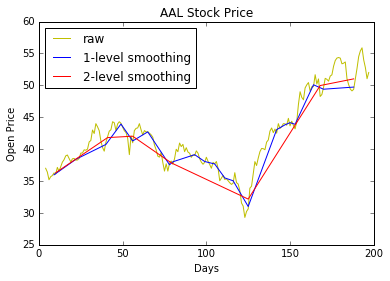

In [9]:
plt.plot(list(range(Pts[0], Pts[-1])), data[Pts[0]:Pts[-1]], 'y', label='raw') # raw data
plt.plot(LPts1, [conv_data[p] for p in LPts1], 'b', label='1-level smoothing') # one smoothing
plt.plot(LPts2, [conv_data2[p] for p in LPts2], 'r', label='2-level smoothing') # two smoothing
plt.legend(loc='upper left')

plt.xlabel('Days')
plt.ylabel('Open Price')
plt.title('AAL Stock Price')

#plt.savefig('results/AAL_smooth.png', dpi=400)

## Pattern Detection

In [10]:
def preprocess(data):
    """ Read data, perform 2 levels of smoothing, and obtain parameters for the Vs. 
        Return 
               Ss: list of paramters for each V where the Vs are obtained from smoothened data. 
              Pts: list of starting points of each V.
             LPts: list of dips of each V.
        conv_data: data after 2 round of smoothing. """ 
    
    _, _, _, m = get_Vectors(data)
    conv_data = np.convolve(data, [1/m]*m, 'same')
    _, _, LPts, m = get_Vectors(conv_data)
    conv_data = np.convolve(conv_data, [1/m]*m, 'same')
    Vs, Pts, _, _ = get_Vectors(conv_data)
    Ss = [getParams(v) for v in Vs]
    
    return Ss, Pts, LPts, conv_data

In [11]:
def preprocessW(data):
    """ Read data, perform 2 levels of smoothing, and obtain parameters for the Vs. 
        Return 
               Ss: list of paramters for each V where the Vs are obtained from smoothened data. 
              Pts: list of starting points of each V.
             LPts: list of dips of each V.
        conv_data: data after 2 round of smoothing. 
        
        Note: the difference between this as preprocess(data) is that LPts in this case is from 2-level 
        smoothing, while preprocess(data) uses LPts from 1-level smoothing.
    """ 
    
    _, _, _, m = get_Vectors(data)
    conv_data = np.convolve(data, [1/m]*m, 'same')
    _, _, _, m = get_Vectors(conv_data)
    conv_data = np.convolve(conv_data, [1/m]*m, 'same')
    Vs, Pts, LPts, _ = get_Vectors(conv_data)
    Ss = [getParams(v) for v in Vs]
    
    return Ss, Pts, LPts, conv_data

In [12]:
def findStartV(Ss):
    """ Find V that is big enough to be significant. 
        Could be modified to use mu[1]+std[1] instead of just mu[1]. 
    """
    
    mu = np.mean(np.array(Ss), axis=0)
    med = np.median(np.array(Ss), axis=0)
    std = np.std(np.array(Ss), axis=0)
    
    if mu[1] > 12 and med[1] > 12: # In case of extremely fluctuating data
        m = 12
    elif mu[1] < med[1]: # otherwise, we want to find as many candidates as possible
        m = mu[1]
    else:
        m = med[1]
        
    candidates = []
    for i in range(len(Ss)):
        if Ss[i][1] > m:
            candidates.append(i)
            
    return candidates

In [13]:
def findCup(data, startTime, params):
    """ Encode the rule for creating a cup. Return all starting and ending points for cup & handle patterns in the
        data window we're interested in. """
    
    window = params['window']
    minPatternLen = params['minPatternLen']
    endptThre = params['endptThre']
    midptThre = params['midptThre']
    
    data = data[startTime-window:startTime] # Get the window of data we want
    Ss, Pts, LPts, conv_data = preprocess(data)
    candidates = findStartV(Ss) # Find possible starting points of cup & handle patterns
    patterns = []
    
    for c in candidates:
        left_val = data[Pts[c]]
        for i in range(c+1, len(Ss)):
            if Pts[i]-Pts[c] > minPatternLen and abs(data[Pts[i]]-left_val) < endptThre:
                # If the right end is "far enough" away from left end and two ends are at "similar" heights
                # We recognize this as the cup.
                for j in range(len(LPts)):
                    if LPts[j] > Pts[i]: # Find the first dip after the cup's right end to be the handle's end.
                        patterns.append([Pts[c], LPts[j]])
                        break
                break
                
            elif data[Pts[i]]-data[LPts[c]] > midptThre*(data[Pts[c]]-data[LPts[c]]): 
                # If there's a peak that's "too high" to be the bottom of the cup but not close enough to
                # left end to be the cup's right end.
                break
                
            
                
    return patterns, conv_data

In [14]:
def findDoubleBottom(data, startTime, params):
    """ Encode the rule for creating a W. Return all starting and ending points for W patterns in the
        data window we're interested in. """
    
    window = params['window']
    minPatternLen = params['minPatternLen']
    midptThre = params['midptThre']
    endptThre = params['endptThre']
    
    data = data[startTime-window:startTime] # Get the window of data we want
    Ss, Pts, LPts, conv_data = preprocessW(data)
    candidates = findStartV(Ss) # Find possible starting points of double-bottom patterns
    patterns = []
    
    for c in candidates:
        found = 0
        left_val = data[Pts[c]]
        for i in range(c+2, len(Ss)):
            if data[LPts[i]] < data[LPts[c]] - endptThre: 
                # If there's a dip much lower than first dip, reject the point.
                break
                
            if Pts[i]-Pts[c] > minPatternLen and data[Pts[i]] >= data[Pts[c]]:
                for j in range(c+1, i):
                    if conv_data[Pts[j]] > conv_data[Pts[c]]+endptThre:
                        # If the middle peak is much higher than the left end.
                        found = 1
                        break
                        
                    if conv_data[Pts[j]] < conv_data[Pts[c]]+endptThre and data[Pts[j]]-data[LPts[c]] > midptThre*(data[Pts[c]]-data[LPts[c]]):
                        # If the middle peak is not too high
                        # and the middle peak is high enough to be considered a significant peak
                        
                        if abs(min(conv_data[Pts[c]:Pts[j]]) - min(conv_data[Pts[j]:Pts[i]])) < endptThre:
                            # If the two dips are close enough to each other
                            # Note that the dip is calculated from smoothened data to remove noise
                            patterns.append([Pts[c], Pts[i]])
                            found = 1
                            break  
                        
            if found == 1:
                # Only detect the shortest possible pattern for a candidate.
                break
                
    return patterns, conv_data

In [15]:
# A fixed set of parameters, modify to get different results

# window = how far to look back from the current date
# minPatternLen = minimum number of days that constitutes a meaningful pattern
# endptThre = allowable price difference between points that should ideally be equal
# midptThre = allowable percentage of the pattern's max height for an intermediate peak to be considered meaningful

params = {'window': 200, 'minPatternLen': 10, 'endptThre': 2.0,
         'midptThre': 0.3}

C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\shini\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


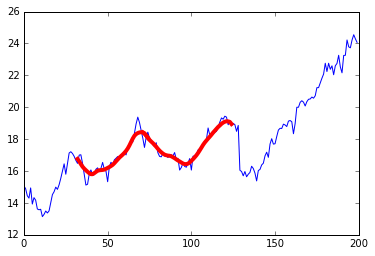

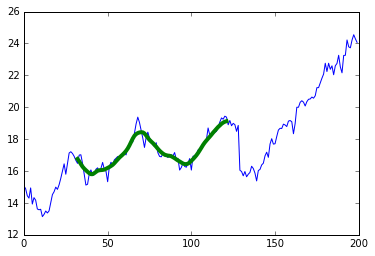

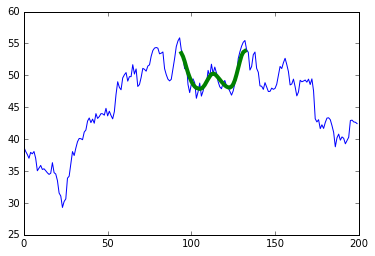

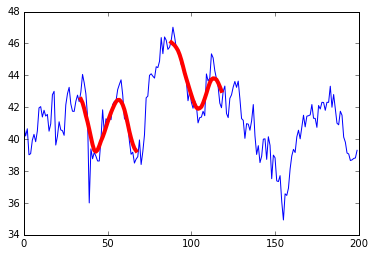

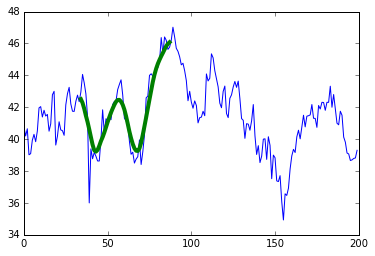

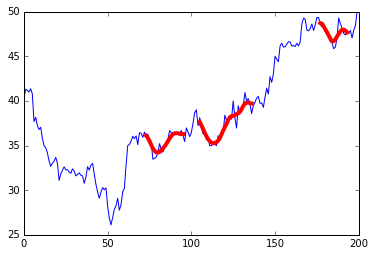

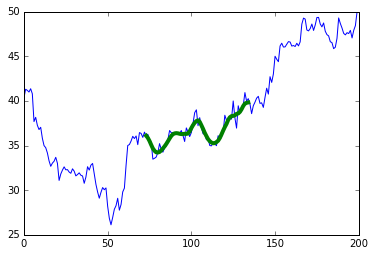

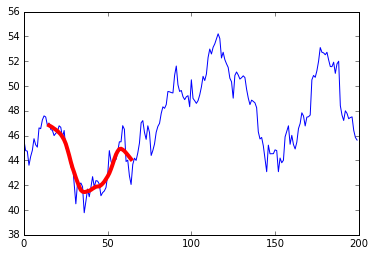

In [18]:
# Run the system on all data
file_dir = 'individual_stocks_5yr'
files = [os.path.basename(elem) for elem in sorted(glob.glob(file_dir+'/*.csv'))]

for i in range(1):#len(files)):
    
    # Read the data
    file = file_dir + '/' + files[i]
    filename = files[i].split('_')[0]
    data = read_data(file)
    
    # Pick current date
    for date in range(200, len(data), 200):
        patterns_cup, conv_data = findCup(data, date, params) # detect cup in the window of data ending at selected date
        patterns_W, _ = findDoubleBottom(data, date, params) # detect W in the window of data ending at selected date
        
        if patterns_cup != []:
            plt.figure()
            plt.plot(list(range(len(data[date-params['window']:date]))), data[date-params['window']:date], 'b')
            
            # Plot all cup-and-handle patterns detected over raw data
            for p in patterns_cup:
                plt.plot(list(range(p[0], p[1])), conv_data[p[0]:p[1]], 'r', linewidth=4)
            #plt.savefig('results/' + filename + '_' + str(i)+' (C).png', dpi=400)
            
        if patterns_W != []:
            plt.figure()
            plt.plot(list(range(len(data[date-params['window']:date]))), data[date-params['window']:date], 'b')
            
            # Plot all double-bottom patterns detected over raw data
            for p in patterns_W:
                plt.plot(list(range(p[0], p[1])), conv_data[p[0]:p[1]], 'g', linewidth=4)
            #plt.savefig('results/' + filename + '_' + str(i)+' (W).png', dpi=400)

## Baseline System

In [19]:
def separateDatasets(data, ratio):
    """ Take first section of the data as training data. 
        The ratio of the training data to the whole dataset
        is specified by the input "ratio"
    """
    
    cut_idx = int(np.around(ratio*len(data)))
    return data[:cut_idx], data[cut_idx:]

In [20]:
def initializePatterns(L):
    """ Initialize desired patterns of length L. """
    
    # cup & handle pattern
    pattern1 = np.interp(np.array(range(L)), [0, int(np.around(0.33*L)), int(np.around(0.67*L)), L-1], [1.0, 0.0, 1.0, 0.7])
    
    # double-bottom pattern
    pattern2 = np.interp(np.array(range(L)), [0, int(np.around(0.25*L)), int(np.around(0.5*L)), int(np.around(0.75*L)), L-1], [1.0, 0.0, 0.5, 0.0, 1.0])
    
    return [pattern1, pattern2]

In [21]:
def calcErr(window, pattern):
    """ Calculate sum of squares error between window and pattern time-series data of same length. """
    
    return np.sum(np.power(window-pattern, 2))

In [22]:
def updatePattern(pattern, window, c):
    """ Calculate an average between the existing pattern and the new data window, 
        where the existing pattern has been previously created from c windows of data.
    """
    
    return ((c/(c+1)) * pattern) + ((1/(c+1)) * window)

In [23]:
def train(path, files, params):
    """ Calculate the template from training data
        path: path to data directory
        files: list of files that constitute the dataset
        params: a dictionary of parameters that will be used in the training process
        
        Return trained version of all patterns
    """
    
    # Extract the parameters from dictionary
    L = params['window'] # window length
    r = params['ratio'] 
    trainThre = params['trainThre'] 
    
    # Initialize the patterns
    patterns = initializePatterns(L)
    counts = [1]*len(patterns)
    
    for file in files:
        
        # Get training data from the specific data file
        data = read_data(path + '/' + file)
        train, _ = separateDatasets(data, r)
        
        for i in range(len(train)-L):
            # Extract a window of data starting at date i
            window = np.array(train[i:i+L])
            
            # Normalize window
            window = window - np.amin(window)
            window = window / np.amax(window)
            
            # Calculate the error between the window and all available patterns
            errs = sorted([(calcErr(window, p), i) for i, p in enumerate(patterns)])
            
            # Find the pattern that matches best
            min_idx = errs[0][1]
            
            # If the best match produces error below the preset threshold, update pattern
            if errs[0][0] < L*trainThre:
                patterns[min_idx] = updatePattern(patterns[min_idx], window, counts[min_idx])
                counts[min_idx] += 1
            
    return patterns

In [31]:
def test(path, file, patterns, params):
    """ Calculate the template from training data
        path: path to data directory
        files: list of files that constitute the dataset
        params: a dictionary of parameters that will be used in the training process
        
        Return a list of dates that are the starts of at least one desirable pattern.
    """
    
    L = params['window']
    r = params['ratio']
    t = params['recogThre']
    found = [[]]*len(patterns)
    
    data = read_data(path + '/' + file)
    _, test = separateDatasets(data, r)
    for i in range(len(test)-L):
        # Plot trained cup-and-handle pattern
        window = np.array(test[i:i+L])
        
        # Calculate the error between the window and all available patterns
        errs = sorted([(calcErr(window, p), i) for i, p in enumerate(patterns)])
        
        # Find the pattern that matches best
        min_idx = errs[0][1]
        
        # Print the minimum error between a pattern and the window
        print("Error for pattern starting at " + str(i) + ": " + str(errs[0][0]))
        
        # If the minimum error is below threshold, we have found a pattern at date i.
        if errs[0][0] < t:
            found[min_idx].append(i)
    
    # If any pattern is found, plot it over raw data.
    if found[0] != [] or found[1] != []:
        plt.figure()
        plt.plot(list(range(len(test))), test, 'b')
        for i in found[0]:
            plt.plot(list(range(L)), patterns[0], 'r', linewidth=4)
        for i in found[1]:
            plt.plot(list(range(L)), patterns[1], 'g', linewidth=4)
        
    return found

In [25]:
# A fixed set of parameters, modify to get different results
baseline_params = {'window': 50, 'ratio': 0.6, 'trainThre': 0.04, 'recogThre': 100}

In [27]:
file_dir = 'individual_stocks_5yr'
files = [os.path.basename(elem) for elem in sorted(glob.glob(file_dir+'/*.csv'))]

# Create templates of patterns with training data
patterns = train(file_dir, files, baseline_params)

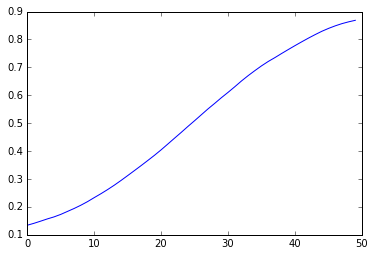

In [28]:
# Plot trained cup-and-handle pattern
plt.plot(list(range(len(patterns[0]))), patterns[0])
plt.savefig('results/trained_cup-handle.png', dpi=400)

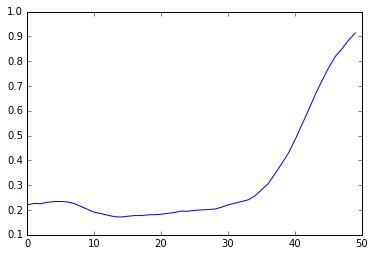

In [29]:
# Plot trained double-bottom pattern
plt.plot(list(range(len(patterns[1]))), patterns[1])
plt.savefig('results/trained_double-bottom.png', dpi=400)

In [32]:
found = test(file_dir, files[0], patterns, baseline_params)

Error for pattern starting at 0: 79904.646499
Error for pattern starting at 1: 80347.7576219
Error for pattern starting at 2: 80434.6834301
Error for pattern starting at 3: 80564.4855406
Error for pattern starting at 4: 80595.8027499
Error for pattern starting at 5: 80501.8755674
Error for pattern starting at 6: 80362.9138812
Error for pattern starting at 7: 80104.4044284
Error for pattern starting at 8: 79804.7981036
Error for pattern starting at 9: 79411.9477657
Error for pattern starting at 10: 78945.5025704
Error for pattern starting at 11: 78463.764579
Error for pattern starting at 12: 77883.0797082
Error for pattern starting at 13: 77264.5217766
Error for pattern starting at 14: 76719.1589712
Error for pattern starting at 15: 76147.3444314
Error for pattern starting at 16: 75529.2825667
Error for pattern starting at 17: 74787.0798567
Error for pattern starting at 18: 74034.3852025
Error for pattern starting at 19: 73380.3790732
Error for pattern starting at 20: 72749.6154132
Erro